<a href="https://colab.research.google.com/github/Kienknu/Kienknu/blob/main/K_SOA_Isoprene_0507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Isoprene

In [ ]:
!pip install rdkit
!pip install molmass

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
from rdkit.Chem import Descriptors
import pandas as pd
import requests
import io
from molmass import Formula

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.0 MB/s eta 0:00:00


# 1. Molecules mass from experimental data

In [ ]:
exp_data = pd.read_excel('SOA_results_NH3_CHON_kien.xlsx',sheet_name='ISO_NH3_CHON')
exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,Neutral_mass,Mono_Abund,Total_Abund,Calc_m/z,#C,#H,#N,#O,#S,H/C,N/C,O/C,S/C
0,NO,3.5,3,C3H3NO,68.014280,69.021556,20364.30,20364.30,68.014187,3,3,1,1,0,1.0000,0.3333,0.3333,0
1,N2O,3.5,3,C2H2N2O,69.009509,70.016785,56457.17,56457.17,69.009436,2,2,2,1,0,1.0000,1.0000,0.5000,0
2,NO,1.5,1,C3H7NO,72.045571,73.052847,133767.85,133928.43,72.045487,3,7,1,1,0,2.3333,0.3333,0.3333,0
3,NO,3.5,3,C4H5NO,82.029900,83.037176,45922.97,45922.97,82.029837,4,5,1,1,0,1.2500,0.2500,0.2500,0
4,N2O,3.5,3,C3H4N2O,83.025136,84.032412,4041310.24,4145474.81,83.025086,3,4,2,1,0,1.3333,0.6667,0.3333,0


In [ ]:
# Experiment file
#url = "https://docs.google.com/spreadsheets/d/1pBx8tnFjT5FHe-KaPjAOxNMYgYAr6ie-/edit?usp=sharing&ouid=105784435570061437896&rtpof=true&sd=true"

# spreadsheet ID
#spreadsheet_id = url.split("/d/")[1].split("/")[0]

# Excel export URL
#excel_export_url = f"https://docs.google.com/spreadsheets/d/{spreadsheet_id}/export?format=xlsx"

# Download
#response = requests.get(excel_export_url)
#response.raise_for_status()

# Read
#exp_data = pd.read_excel(io.BytesIO(response.content), sheet_name='ISO_NH3_CHON', engine='openpyxl')

#exp_data.head()

In [ ]:
# Mass calculation from data
def calculate_monoisotopic_masses(formula):
    try:
        f = Formula(formula)
        mono_mass = f.isotope.mass  # Monoisotopic mass
        mh_mass = mono_mass - 1.007825  # [M-H]
        mph_mass = mono_mass + 1.007825  # [M+H]
        return mono_mass, mh_mass, mph_mass
    except Exception as e:
        print(f"Error with formula {formula}: {e}")
        return None, None, None

# Add new column to the dataframe:
exp_data[['Neutral_Mass', '[M-H]', '[M+H]']] = exp_data['Formula'].apply(
    lambda x: pd.Series(calculate_monoisotopic_masses(x))
)


exp_data.head()

,Class,DBE,Neutral_DBE,Formula,Exp_m/z,Neutral_mass,Mono_Abund,Total_Abund,Calc_m/z,#C,...,#N,#O,#S,H/C,N/C,O/C,S/C,Neutral_Mass,[M-H],[M+H]
0,NO,3.5,3,C3H3NO,68.014280,69.021556,20364.30,20364.30,68.014187,3,...,1,1,0,1.0000,0.3333,0.3333,0,69.021464,68.013639,70.029289
1,N2O,3.5,3,C2H2N2O,69.009509,70.016785,56457.17,56457.17,69.009436,2,...,2,1,0,1.0000,1.0000,0.5000,0,70.016713,69.008888,71.024538
2,NO,1.5,1,C3H7NO,72.045571,73.052847,133767.85,133928.43,72.045487,3,...,1,1,0,2.3333,0.3333,0.3333,0,73.052764,72.044939,74.060589
3,NO,3.5,3,C4H5NO,82.029900,83.037176,45922.97,45922.97,82.029837,4,...,1,1,0,1.2500,0.2500,0.2500,0,83.037114,82.029289,84.044939
4,N2O,3.5,3,C3H4N2O,83.025136,84.032412,4041310.24,4145474.81,83.025086,3,...,2,1,0,1.3333,0.6667,0.3333,0,84.032363,83.024538,85.040188


#2. Reactions of Isoprene with different species

In [ ]:
chemical_space_1 = {'C=CC(=C)C'}  # Isoprene

reacting_species_1 = {'[OH]', '[N](=O)', '[N+](=O)[O-]', 'O=O', 'N([H])([H])[H]'}
num_iterations_1 = 4

In [ ]:
reaction_rules_1 = [

    AllChem.ReactionFromSmarts('[C:1]>>[C:1][N+](=O)[O-]'),          # 0.Nitration_1 (NO₂ addition): n=1>>0.14%,n=2>>0.28%      n=3>>0.28%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N+](=O)[O-]'),       # 1.Nitration_2                                            n=3>>0.85%

    AllChem.ReactionFromSmarts('[C:1]>>[C:1][N]=O'),                 # 2.Nitrosation_1 (NO addition): n=2>>0.14%, n=3,4>>0.28%  n=3>>1.42%
    AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][N](=O)'),            # 3.Nitrosation_2                                          n=3>>2.13%

    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(=O)O'),                # 4.Carboxylation (COOH addition): n=2>>0%                 n=3>>5.52%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(=O)'),                 # 5.Carbonylation (CO addition): n=2>>0%                   n=3>>5.96%
    AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][C:2]'),            # 6.Generic carbon coupling: n=2>>0%                       n=3>>6.52%
    AllChem.ReactionFromSmarts('[C:1]>>[C:1]OO'),                    # 7.Alkyl to hydroperoxide (ROOH addition): n=2>>0%        n=3>>7.80%

    AllChem.ReactionFromSmarts('[C:1]>>[C:1][NH2]'),                 # 8.Amination_1: n=2>>0%                                   n=3>>9.36%

    AllChem.ReactionFromSmarts('[C:1]>>[C:1][*]'),                   # 9.Radical generation: n=3>>0%                            n=3>>18.30%
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2]'),       # 10.Alkene to alcohol                                     n=3>>19.43%
    AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](O)-[C:2](O)'),    # 11.Dihydroxylation                                       n=3>>20.14%
    AllChem.ReactionFromSmarts('[C:1][C:2]>>[C:1]C(C)[C:2]'),        # 12.Carbon chain branching addition                       n=3>>20.57%
    AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1](C=CC(=C)C)'),      # 13.Self polimerization                                   n=3>>23.12%
    AllChem.ReactionFromSmarts('[C:1](O)C>>[C:1]'),                  # 14.Dehydration                                           n=3>>22.98%

    # ************List of TESTED rules*********** #

    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][NH2]'),              # 15.Amination_2                                           n=3>>9.65%
    #AllChem.ReactionFromSmarts('[C:1][N+](=O)[O-]>>[C:1](=O)N(=O)'), # 16.Nitro to nitroso conversion                           n=3>>23.12%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][N](=O)'),            # 17.                                                      n=3>>23.12%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][N+](=O)[O-]'),       # 18.                                                      n=3>>23.12%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1]C(=O)O'),             # 19.                                                      n=3>>23.12%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][C:2]'),              # 20.                                                      n=3>>23.12%
    #AllChem.ReactionFromSmarts('[*:1][*]>>[*:1][OH]'),               # 21.                                                      n=3>>22.98%
    #AllChem.ReactionFromSmarts('[C:1][*:2]>>[C:1][OH]'),             # 22.                                                      n=3>>22.98%
    #AllChem.ReactionFromSmarts('[C:1][OH]>>[C:1]=O'),                # 23.Oxidation of Alcohol to carbonyl                      n=3>>17.59%


    #AllChem.ReactionFromSmarts('[C:1]=[C:2]>>[C:1](=O).[C:2](=O)'),  # 24.Ozonolysis                                            n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]C(=O)O'),             # 25.Generic carboxylation                                 n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1]OO'),                 # 26.Generic hydroperoxide formation (ROOH)                n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][OH]'),               # 27.Generic hydroxylation                                 n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1](C=CC(=C)C)'),        # 28.polymerization                                        n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][NH2]'),              # 29.Generic amination                                     n=3>>12.91%

    #AllChem.ReactionFromSmarts('[C:1](C[OH])>>[C:1](C=O)'),         # 30.Alcohol Oxidation                                     n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1](C=O)>>[C:1](C(=O)O)'),        # 31.Aldehyde to carboxylic acid                           n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1][*]>>[C:1][C:2]'),             # 32.Radial coupling                                       n=3>>12.91%
    #AllChem.ReactionFromSmarts('[C:1](=O)OO>>[C:1](=O)O'),          # 33.Peroxy acid to carboxylic acid                        n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1](O)>>[C:1][NH2]'),             # 34.Alcohol to amine                                      n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N]=O'),             # 35.Peroxynitrite formation                               n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[N+](=O)[O-]'),      # 36.Peroxynitrite formation                               n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1][O][O]>>[C:1][O]'),            # 37.Hydroperoxide to alcohol(OOH to OH)                   n=3>>7.38%

    #AllChem.ReactionFromSmarts('[C:1](OO)>>[C:1]=O'),               # 38.ROOH to carbonyl (oxidation)                          n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O'),                  # 39.ROO• to to carbonyl (oxidation of hydroperoxide)      n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]OO>>[C:1]O[O]'),               # 40.ROO• to peracid                                       n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1](=O)O>>[C:1](=O)[NH2]'),       # 41.Carboxylic acid to amide                              n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]C(=O)[O-]>>[C:1]C(=O)[NH2]'),  # 42.Ammonolysis                                           n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)'),                 # 43.Oligomer-like C Extension (2-carbon branch)           n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]>>[C:1]C(C)(C)'),              # 44.Oligomer-like C Extension (3-carbon branch)           n=3>>7.38%
    #AllChem.ReactionFromSmarts('[C:1]=O>>[C:1]=N[O]'),              # 45.Oxime-like formation                                  n=3>>7.38%
]

In [ ]:
# Function to create radical
def create_radical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    radical = Chem.MolFromSmarts("[C*]")

    if mol.HasSubstructMatch(radical):
      Chem.rdmolops.SanitizeMol(mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
      return Chem.MolToSmiles(mol)
    else:
      return None

# Comparison conditions
tolerance = 0.0000001  # 0.1ppm

matching_smiles_1 = []
matching_excel_info = []

excel_mw_neg = exp_data['[M-H]'].tolist()
excel_mw_neu = exp_data['Neutral_Mass'].tolist()
excel_mw_pos = exp_data['[M+H]'].tolist()

# Initial conditions
max_mass = 650.0
max_carbons = 36
max_nitrogens = 4
max_oxygens = 17

# Reaction for chemical_space_1
reaction_history_1 = []
all_matching_smiles = set()

for _ in range(num_iterations_1):
    temp_new_products = set()
    for reactant_smiles in chemical_space_1.copy():
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        if reactant_mol:

            # Apply reaction rules
            for rxn_index, rxn in enumerate(reaction_rules_1):
                possible_products = rxn.RunReactants((reactant_mol,))
                for prod_set in possible_products:
                    for prod in prod_set:
                        try:
                            prod_smiles = Chem.MolToSmiles(prod)
                            prod_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(prod_smiles), canonical=True)

                            # radical correction
                            if "[C*]" in prod_smiles:
                                prod_smiles = create_radical(reactant_smiles)

                            # Valence check
                            prod_mol = Chem.MolFromSmiles(prod_smiles,sanitize=False)
                            if prod_mol.GetNumAtoms() > 0:
                              try:
                                Chem.rdmolops.SanitizeMol(prod_mol, Chem.rdmolops.SanitizeFlags.SANITIZE_ALL)
                              except:
                                pass

                              if len(Chem.DetectChemistryProblems(prod_mol)) == 0:

                                # Check and add to temp_new_products and reaction_history
                                if prod_smiles not in chemical_space_1:
                                    temp_new_products.add(prod_smiles)
                                    # Check if the product is a match and update is_match
                                    is_match = False

                                    # Check within the inner loop
                                    calculated_mw_temp = Descriptors.ExactMolWt(prod_mol)
                                    for excel_mw_list, excel_column in zip(
                                    [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']):
                                        for excel_mw_value in excel_mw_list:
                                            diff = abs(calculated_mw_temp - excel_mw_value)
                                            if diff <= tolerance:
                                                is_match = True
                                                all_matching_smiles.add(prod_smiles)
                                                break
                                        if is_match:
                                            break

                                    reaction_history_1.append((reactant_smiles, rxn_index, prod_smiles, prod_smiles in all_matching_smiles))


                        except:
                            pass

            # React with reacting species
            for species in reacting_species_1:
                try:
                    combined_smiles = reactant_smiles #+ "." + species
                    combined_mol = Chem.MolFromSmiles(combined_smiles)

                    if combined_mol:
                      # Mass check for reacting species
                      if Descriptors.ExactMolWt(combined_mol) <= max_mass:
                        temp_new_products.add(Chem.MolToSmiles(combined_mol))
                except:
                    pass

    chemical_space_1.update(temp_new_products)

# Apply threshold
chemical_space_1 = {smi for smi in chemical_space_1
                           if Descriptors.ExactMolWt(Chem.MolFromSmiles(smi)) <= max_mass
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 6) <= max_carbons
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 7) <= max_nitrogens
                           and sum(1 for atom in Chem.MolFromSmiles(smi).GetAtoms() if rdkit.Chem.rdchem.GetPeriodicTable().GetAtomicNumber(atom.GetSymbol()) == 8) <= max_oxygens}

# Create mols_1 and valid_smiles_1 from chemical_space_1
mols_1 = [Chem.MolFromSmiles(smi) for smi in chemical_space_1]
valid_smiles_1 = list(chemical_space_1)

Streaming output truncated to the last 5000 lines.
[07:28:43] Explicit valence for atom # 6 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 8 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 6 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 8 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 1 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 7 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 3 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 7 C, 5, is greater than permitted
[07:28:43] Explicit valence for atom # 3 C, 5, is greater than permitted


In [ ]:
print(len(chemical_space_1))
print(len(mols_1))

409448
409448


#3. Comparison of matched percentages

In [ ]:
# Mass calculation and comparison for mols_1

calculated_mw_1 = []
for mol in mols_1:
  mw = Chem.Descriptors.ExactMolWt(mol)
  calculated_mw_1.append(mw)

for i, calculated_mw_value in enumerate(calculated_mw_1):
    for excel_mw_list, excel_column in zip(
        [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
    ):
        for j, excel_mw_value in enumerate(excel_mw_list):
            diff = abs(calculated_mw_value - excel_mw_value)

            if diff <= tolerance and valid_smiles_1[i] not in matching_smiles_1:
                matching_smiles_1.append(valid_smiles_1[i])
                all_matching_smiles.add(valid_smiles_1[i])

                # Check if the product is match
                is_match = True
            else:
                is_match = False

            reaction_history_1.append((reactant_smiles, rxn_index,prod_smiles, is_match))


            break

# Find matching indices based on all_matching_smiles
matching_excel_info_all = []
for smi in all_matching_smiles:
  calculated_mw_value = Chem.Descriptors.ExactMolWt(Chem.MolFromSmiles(smi))
  for excel_mw_list, excel_column in zip(
      [excel_mw_neg, excel_mw_neu, excel_mw_pos], ['[M-H]', 'Neutral_Mass', '[M+H]']
  ):
    for j, excel_mw_value in enumerate(excel_mw_list):
      diff = abs(calculated_mw_value - excel_mw_value)

      if diff <= tolerance:
        row_index = exp_data.index[exp_data[excel_column] == excel_mw_value].tolist()[0]
        matching_excel_info_all.append((row_index, excel_column))
        break

# Get all row in the Excel file
all_excel_indices = set(exp_data.index)

matching_indices_set = set(matching_excel_info_all)
matching_percentage = (len(matching_indices_set) / len(all_excel_indices)) * 100

print(f"Matching percentage: {matching_percentage:.2f}%")

Matching percentage: 50.64%


#4. Ranking reaction rules by its contribution to matched percentages

In [ ]:
# After the simulation and matching:
rule_contributions = {}
for reactant_smiles, rxn_index, product_smiles, is_match in reaction_history_1:
    rule_contributions.setdefault(rxn_index, {'total': 0, 'matches': 0})
    rule_contributions[rxn_index]['total'] += 1
    if is_match:
        rule_contributions[rxn_index]['matches'] += 1

ranked_rules = sorted(rule_contributions.items(), key=lambda item: item[1]['matches'] / item[1]['total'], reverse=True)

for rxn_index, stats in ranked_rules:
    print(f"Rule {rxn_index}: Contribution Score = {stats['matches'] / stats['total']:.2f}")

Rule 1: Contribution Score = 0.39
Rule 0: Contribution Score = 0.39
Rule 3: Contribution Score = 0.36
Rule 2: Contribution Score = 0.32
Rule 4: Contribution Score = 0.28
Rule 9: Contribution Score = 0.28
Rule 5: Contribution Score = 0.24
Rule 7: Contribution Score = 0.23
Rule 11: Contribution Score = 0.16
Rule 10: Contribution Score = 0.13
Rule 8: Contribution Score = 0.12
Rule 6: Contribution Score = 0.10
Rule 12: Contribution Score = 0.06
Rule 13: Contribution Score = 0.03
Rule 14: Contribution Score = 0.00


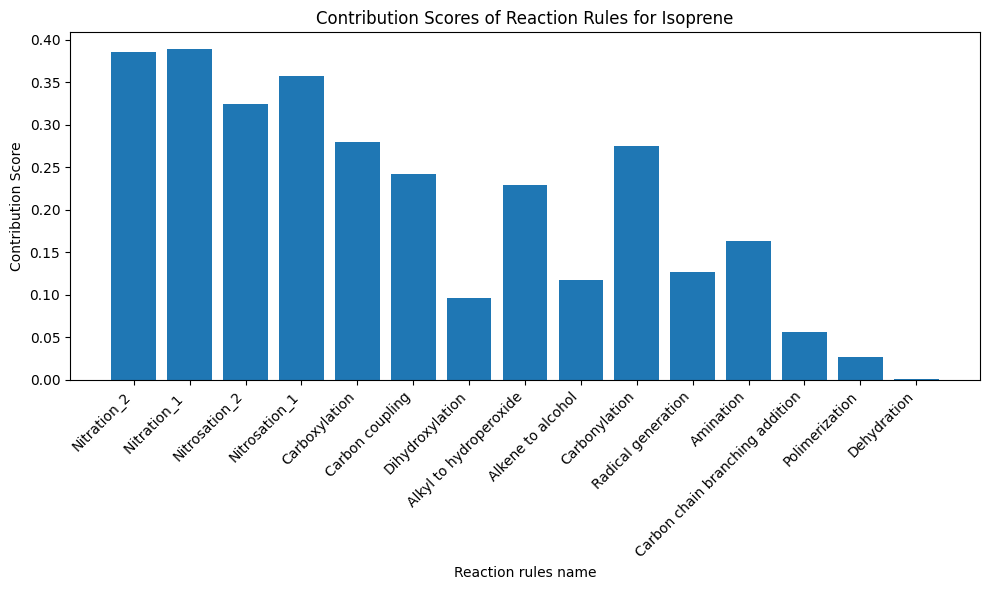

In [ ]:
# Create a chart
import matplotlib.pyplot as plt

rule_names = [
    "Nitration_1 ",#0
    "Nitration_2",#1
    "Nitrosation_1",#2
    "Nitrosation_2",#3
    "Carboxylation",#4
    "Carbonylation",#5
    "Carbon coupling",#6
    "Alkyl to hydroperoxide",#7
    "Amination",#8
    "Radical generation",#9
    "Alkene to alcohol",#10
    "Dihydroxylation",#11
    "Carbon chain branching addition",#12
    "Polimerization",#13
    "Dehydration",#14
]
rule_indices = [rxn_index for rxn_index, stats in ranked_rules]
scores = [stats['matches'] / stats['total'] for rxn_index, stats in ranked_rules]

plt.figure(figsize=(10, 6))
plt.bar(rule_indices, scores)
plt.xlabel("Reaction rules name")
plt.ylabel("Contribution Score")
plt.title("Contribution Scores of Reaction Rules for Isoprene")
plt.xticks(rule_indices, rule_names,rotation=45, ha='right')
plt.tight_layout()

plt.grid(False)
plt.show()

In [ ]:
# Save distribution scores
import csv

with open('rule_contributions.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Rule Index', 'Contribution Score'])
    for rxn_index, stats in ranked_rules:
        score = stats['matches'] / stats['total']
        writer.writerow([rxn_index, score])

#5. Pathways

Reaction pathway for *C=C(C*)N=O:


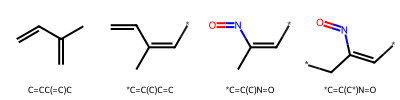

--------------------
Reaction pathway for *CC=CN=O:


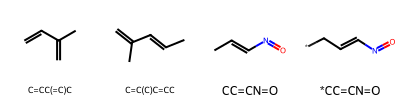

--------------------
Reaction pathway for *C(=C)CN=O:


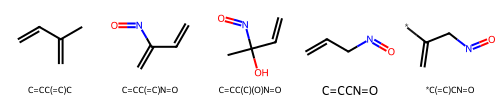

--------------------
Reaction pathway for *C(N)=CC=O:


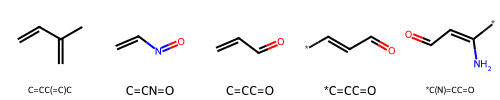

--------------------
Reaction pathway for *CC(*)=CN=O:


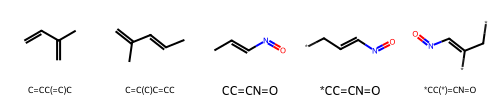

--------------------
Reaction pathway for *C(=O)C(=C)N:


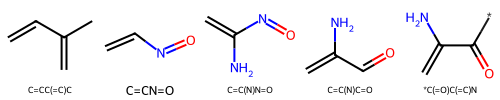

--------------------
Reaction pathway for *C=CC(N)=O:


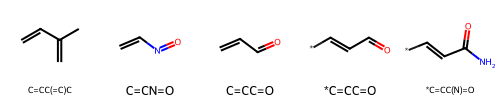

--------------------
Reaction pathway for *C(C=C)N=O:


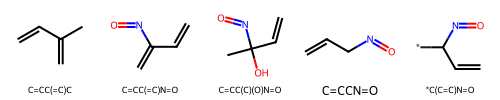

--------------------
Reaction pathway for *C(*)(*)C(=C)N=O:


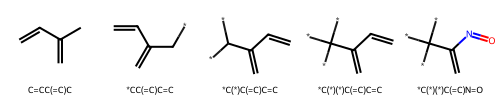

--------------------
Reaction pathway for *C(C=O)=CN:


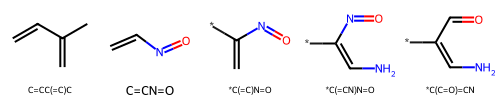

--------------------


In [ ]:
# Visualization of pathways

num_smiles_to_trace = 10

# Trace reaction Function
def trace_reaction_path(target_product_smiles, reaction_history_1):
    """Traces the reaction pathway through reaction_history_1"""

    reaction_path = []
    current_product = target_product_smiles

    # Search in reaction_history_1
    while current_product:
        found_in_history = False
        for i in range(len(reaction_history_1) - 1, -1, -1):
            if reaction_history_1[i][2] == current_product:
                reaction_path.insert(0, reaction_history_1[i])
                current_product = reaction_history_1[i][0]
                found_in_history = True
                break

        if not found_in_history:
            current_product = None

    return reaction_path

# Visualizing the pathways
for i, product_smiles in enumerate(matching_smiles_1):
    if i >= num_smiles_to_trace:
        break

    pathway = trace_reaction_path(product_smiles, reaction_history_1)

    if pathway:
        print(f"Reaction pathway for {product_smiles}:")

        # Collect molecules
        pathway_molecules = [Chem.MolFromSmiles(pathway[0][0])]
        legends = [pathway[0][0]]

        for step in pathway:
            reactant, rxn_index, product, is_match = step
            product_mol = Chem.MolFromSmiles(product)

            if product_mol is not None and product_mol not in pathway_molecules:
                pathway_molecules.append(product_mol)
                legends.append(product)

        img = Draw.MolsToGridImage(pathway_molecules, molsPerRow=len(pathway_molecules),
                                   subImgSize=(100, 100), legends=legends, useSVG=True)
        display(img)
        print("-" * 20)